![Semillero Astrofisica](../logo.PNG)

---
# Sistemas de Ecuaciones Diferenciales Ordinarias

Carlos Andrés del Valle (cdelv@unal.edu.co)

---

Vamos a resolver el sistema de ecuaciones que corresponde a uno de los modelos más simples de epidemias. El modelo SIR.

\begin{equation}
    \begin{split}
        & \frac{ds(t)}{dt} = -bs(t)i(t) \\
        & \frac{di(t)}{dt} = bs(t)i(t)-ki(t) \\
        & \frac{dr(t)}{dt} = ki(t) \\
    \end{split}
\end{equation}

con $b=1/2$ y $k=1/3$. Las condiciones iniciales son
\begin{equation}
    \begin{split}
        & s(0)=0.95 \\
        & i(0)=0.05\\
        & r(0)=0 \\
    \end{split}
\end{equation}

In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

#Usar doble precisión si la GPU lo soporta. Float32 por defecto.
dde.config.real.set_float64()

Using backend: tensorflow.compat.v1

2022-10-19 23:31:50.977180: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-19 23:31:50.980901: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-19 23:31:50.980941: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2022-10-19 23:31:52.167206: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-19 23:31:52.167248: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


## 1. Definir la Ecuación a Resolver

In [2]:
b = 1/2
k = 1/3

def ode_system(x, y):
    s, i, r = y[:, 0:1], y[:, 1:2], y[:, 2:]
    ds_dt = dde.grad.jacobian(y, x, i=0)
    di_dt = dde.grad.jacobian(y, x, i=1)
    dr_dt = dde.grad.jacobian(y, x, i=2)
    return [ds_dt + b*s*i, 
            di_dt - b*s*i + k*i, 
            dr_dt - k*i,
           ]

## 2. Definir Dominio de la Ecuación

Como tenemos solo dependencia temporal, podemos aprovechar el dominio TimeDomain

~~~python
class deepxde.geometry.timedomain.TimeDomain(t0, t1)
~~~

Esta clase de dominio crea el booleano para definir las coondiciones iniciales

~~~pyhton
on_initial(t)
~~~

In [3]:
geom = dde.geometry.TimeDomain(0, 35)

## 3. Definir Condiciones Iniciales y de Frontera

~~~python
class deepxde.icbc.initial_conditions.IC(geom, 
                                         func, 
                                         on_initial, 
                                         component=0)
~~~

Initial conditions: y([x, t0]) = func([x, t0])

In [4]:
def boundary(_, on_initial):
    return on_initial

inf = 5e-2

ic1 = dde.icbc.IC(geom, lambda x: 1-inf, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x:   inf, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda x:     0, boundary, component=2)

## 4. Crear Datos de Entrenamiento

vamos a crear los datos de entrenamiento

~~~python
class deepxde.data.pde.TimePDE(geometryxtime, 
                               pde, 
                               ic_bcs, 
                               num_domain=0, 
                               num_boundary=0, 
                               num_initial=0, 
                               train_distribution='Hammersley', 
                               anchors=None, 
                               exclusions=None, 
                               solution=None, 
                               num_test=None, 
                               auxiliary_var_function=None
~~~

Detalles en https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html?highlight=data.TimePDE#deepxde.data.pde.TimePDE. 

In [5]:
data = dde.data.PDE(geom, ode_system, [ic1, ic2, ic3], 62, 8, num_test=0)

## 5. Crear la Red Neuronal

Vamos a utilizar una **Fully-connected neural network**.

~~~python
class deepxde.nn.tensorflow.fnn.FNN(layer_sizes, activation, 
                                    kernel_initializer, 
                                    regularization=None, 
                                    dropout_rate=0)
~~~

In [6]:
layer_size = [1] + [40]*3 + [3]  # Hay 3 salidas: (s, i, r)
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

## 6. Compilar y Entrenar el Modelo

Vamos a usar LBFGS para tener una buena convergencia. Adam no funciona bien en este tipo de problemas.

In [7]:
# Modelo
model = dde.Model(data, net)

# Optimizador L-BFGS
dde.optimizers.config.set_LBFGS_options(maxiter=5000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.036547 s



/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-10-19 23:31:53.562182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.249096 s

Initializing variables...
Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.89e-04, 2.27e-01, 1.71e-01, 9.02e-01, 2.50e-03, 0.00e+00]    [nan, nan, nan, 9.02e-01, 2.50e-03, 0.00e+00]                   []  


2022-10-19 23:31:53.779399: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


1000      [1.43e-09, 2.17e-09, 1.30e-09, 3.07e-14, 9.83e-13, 7.78e-13]                                                                        
2000      [5.00e-11, 1.58e-10, 2.05e-10, 1.95e-16, 1.81e-14, 6.84e-14]                                                                        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  Objective function value: 0.000000
  Number of iterations: 2648
  Number of functions evaluations: 2993
2993      [2.37e-11, 1.12e-10, 3.77e-11, 8.28e-18, 2.09e-17, 2.46e-17]    [nan, nan, nan, 8.28e-18, 2.09e-17, 2.46e-17]                   []  

Best model at step 2993:
  train loss: 1.73e-10
  test loss: nan
  test metric: []

'train' took 10.916892 s



## 7. Visualizar la Solución

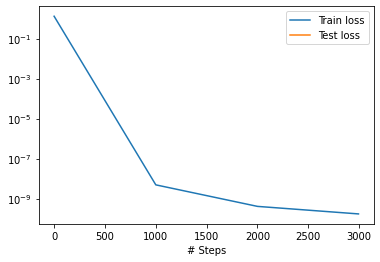

In [8]:
dde.utils.external.plot_loss_history(losshistory)

~~~python
uniform_points(n, boundary=True)
~~~

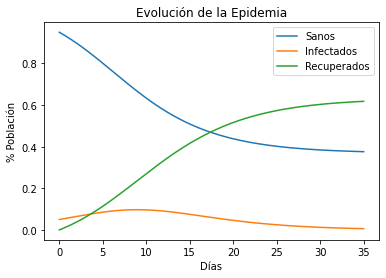

In [9]:
#geom = dde.geometry.TimeDomain(0, 140)
t = geom.uniform_points(1000)
y = model.predict(t)

plt.plot(t,y[:,0],label="Sanos")
plt.plot(t,y[:,1],label="Infectados")
plt.plot(t,y[:,2],label="Recuperados")
plt.title('Evolución de la Epidemia')
plt.xlabel('Días')
plt.ylabel('% Población')
plt.legend()
plt.show()